## Impact of denoising as one increases


In [1]:
#! lamin init --storage ./lamin-intro --schema bionty

import scanpy as sc
from scprint2 import scPRINT2
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download

from scprint2.tasks import Denoiser, withknn
from scprint2.model.utils import downsample_profile
from scipy.stats import spearmanr
from anndata import AnnData
from scprint2.tasks.denoise import plot_cell_depth_wise_corr_improvement

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import torch

torch.set_float32_matmul_precision("medium")

→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [2]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../models/18hebyht-final-small.ckpt"
# w937u4o1
# l2su2z5q

In [11]:
# v1 model version
model_checkpoint_file = "../models/ogvvg2z7-v1.ckpt"

In [12]:
model = scPRINT2.load_from_checkpoint(
    model_checkpoint_file, precpt_gene_emb=None, gene_pos_file=None
)
model = model.to("cuda")

FYI: scPrint is not attached to a `Trainer`.


# run denoising as depth increase


In [ ]:
# import lamindb as ln

# res = ln.Artifact.filter(uid="vhwQPOwZ3kyGtOv00001")[0]
# print(res.key)
# print(res.path)
# print()
# res = ln.Artifact.filter(uid="Q1fKksCKtOAgigiT0001")[0]
# print(res.key)
# print(res.path)

# 2025-02-25/h5ad/Velocyto/Homo_sapiens/SRX24486462.h5ad
# /pasteur/appa/scratch/jkalfon/scprint2/.lamindb/vhwQPOwZ3kyGtOv00001.h5ad

# 2025-02-25/h5ad/Velocyto/Homo_sapiens/SRX22526970.h5ad
# /pasteur/appa/scratch/jkalfon/scprint2/.lamindb/Q1fKksCKtOAgigiT0001.h5ad

In [10]:
LOC = "/pasteur/appa/scratch/jkalfon/data/spcrint_data/temp/"  # "../../data/temp/"  #

datasets = {
    "retina": "https://datasets.cellxgene.cziscience.com/53bd4177-79c6-40c8-b84d-ff300dcf1b5b.h5ad",  # gNNpgpo6gATjuxTE7CCp
    "kidney": "https://datasets.cellxgene.cziscience.com/01bc7039-961f-4c24-b407-d535a2a7ba2c.h5ad",
    "pancreas": "https://figshare.com/ndownloader/files/24539828",
    "intestine": "https://datasets.cellxgene.cziscience.com/d9a99b4a-3755-47c4-8eb5-09821ffbde17.h5ad",  # R4ZHoQegxXdSFNFY5LGe in my case # R4ZHoQegxXdSFNFYMaIQ
    "glio_smart_highdepth": "https://datasets.cellxgene.cziscience.com/6ec440b4-542a-4022-ac01-56f812e25593.h5ad",  # s8x0Idi587LQtXCo0Pif
    "lung_smart": "https://datasets.cellxgene.cziscience.com/6ebba0e0-a159-406f-8095-451115673a2c.h5ad",
    # additional (see origin from block above)
    "SRX24486462": None,
    "SRX22526970": None,
    #
}

# we use 8K genes everywhere on the entire dataset (and the we run scPRINT-V1 without the zero-pred)


doing  retina



/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 51531 renamining
filtered out 0 cells, 51531 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 33737 genes in the ontology but not present in the dataset
starting QC
Seeing 24011 outliers (46.59% of total dataset):
done
AnnData object with n_obs × n_vars = 51531 × 70116
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 1289/1289 [05:44<00:00,  3.75it/s]


logging the anndata
AnnData object with n_obs × n_vars = 51531 × 4661
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
corr with zeros: 
{'reco2full': np.float64(0.3302505701438798), 'noisy2full': np.float64(0.6938151842598811)}
cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': np.float64(0.3013540553941771), 'cell_wise_to_noisy': np.float64(0.19039293320473333)}
depth-wise plot


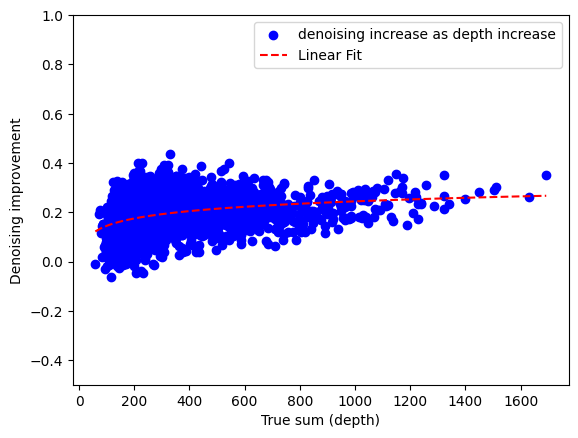

{'reco2noisy': np.float64(0.3278746350045745), 'reco2full': np.float64(0.560861534083903), 'noisy2full': np.float64(0.3581354882343459)}
doing  kidney



/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 39176 renamining
filtered out 0 cells, 39176 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 33718 genes in the ontology but not present in the dataset
starting QC
Seeing 3467 outliers (8.85% of total dataset):
done
AnnData object with n_obs × n_vars = 39176 × 70116
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rpl', 'percent.rps', 'doublet_id', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'tissu

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 1959/1959 [05:22<00:00,  6.08it/s]


logging the anndata
AnnData object with n_obs × n_vars = 39176 × 4793
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
corr with zeros: 
{'reco2full': np.float64(0.36260232841412016), 'noisy2full': np.float64(0.6828909254239218)}
cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': np.float64(0.33547797572318777), 'cell_wise_to_noisy': np.float64(0.15716821044300036)}
depth-wise plot


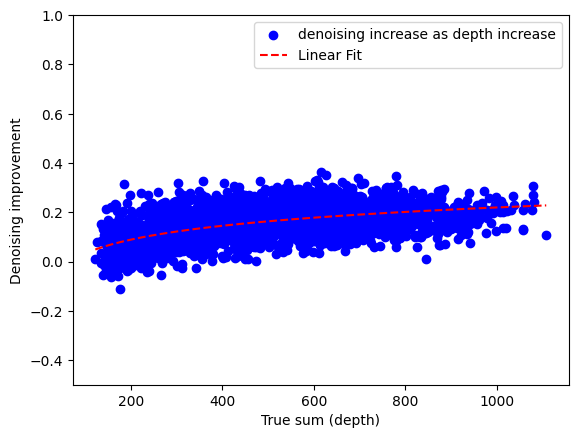

{'reco2noisy': np.float64(0.3577238927505828), 'reco2full': np.float64(0.5460601007689811), 'noisy2full': np.float64(0.345834323286593)}
doing  pancreas

X was not raw counts, using 'counts' layer


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


Dropping layers:  KeysView(LayersView with keys: counts)
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 16382 renamining
filtered out 0 cells, 16382 renamining
Removed 1068 genes not known to the ontology
Removed 0 duplicate genes
Added 52091 genes in the ontology but not present in the dataset
starting QC
Seeing 4678 outliers (28.55% of total dataset):
done
AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'r

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 820/820 [03:16<00:00,  4.17it/s]


logging the anndata
AnnData object with n_obs × n_vars = 16382 × 7875
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
corr with zeros: 
{'reco2full': np.float64(0.3142103089913891), 'noisy2full': np.float64(0.725281406791739)}
cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': np.float64(0.2540283250957106), 'cell_wise_to_noisy': np.float64(0.15377162288185037)}
depth-wise plot


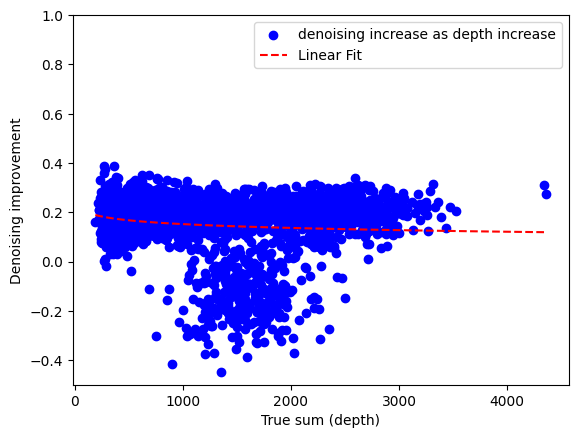

{'reco2noisy': np.float64(0.24281627843804265), 'reco2full': np.float64(0.6644049588845546), 'noisy2full': np.float64(0.3998439828131316)}
doing  intestine



/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


Dropping layers:  KeysView(Layers with keys: ln_rpdm-normalized, raw_rpdm-normalized)
checking raw counts
removed 0 non primary cells, 1466 renamining
filtered out 0 cells, 1466 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 47132 genes in the ontology but not present in the dataset
starting QC
Seeing 1354 outliers (92.30% of total dataset):
done
AnnData object with n_obs × n_vars = 1466 × 70116
    obs: 'hash_label', 'hash_cluster', 'n_genes', 'hashed', 'group', 'treatment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pct_counts_hb', 'batch', 'S_score', 'G2M_score', 'phase', 'leiden', 'lineage', 'type', 'cds', 'donor_region', 'dpt_pseudotime', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 's

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 74/74 [00:09<00:00,  7.90it/s]


logging the anndata
AnnData object with n_obs × n_vars = 1466 × 5289
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
corr with zeros: 
{'reco2full': np.float64(0.3871692758833197), 'noisy2full': np.float64(0.6825583548612522)}
cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': np.float64(0.388035242282371), 'cell_wise_to_noisy': np.float64(0.25137191434027384)}
depth-wise plot


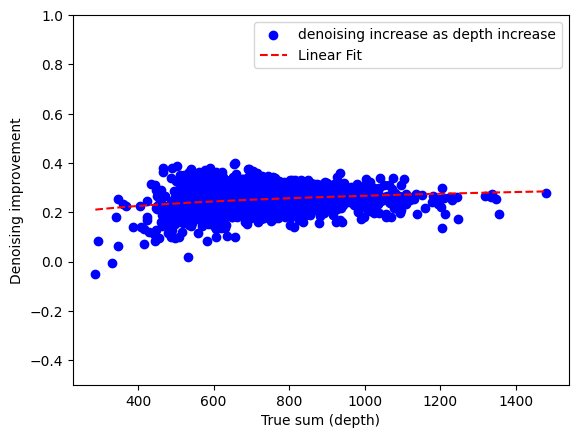

{'reco2noisy': np.float64(0.5249935492008516), 'reco2full': np.float64(0.5995113072880468), 'noisy2full': np.float64(0.3647867065473246)}
doing  glio_smart_highdepth

Dropping layers:  KeysView(LayersView with keys: )
checking raw counts
removed 0 non primary cells, 3566 renamining
filtered out 12 cells, 3554 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 47967 genes in the ontology but not present in the dataset
starting QC
Seeing 71 outliers (2.00% of total dataset):
done
AnnData object with n_obs × n_vars = 3554 × 70116
    obs: 'Sample.type', 'Selection', 'Location', 'Sample.name', 'Total_reads', 'Unique_reads', 'Unique_reads_percent', 'Splice_sites_total', 'Splice_sites_Annotated', 'Splice_sites_GT.AG', 'Splice_sites_GC.AG', 'Splice_sites_AT.AC', 'Splice_sites_non_canonical', 'Multimapping_reads_percent', 'Unmapped_mismatch', 'Unmapped_short', 'Unmapped_other', 'ERCC_reads', 'Non_ERCC_reads', 'ERCC_to_non_ERCC', 'Genes_detected', 'housekeeping

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 178/178 [00:33<00:00,  5.35it/s]


logging the anndata
AnnData object with n_obs × n_vars = 3554 × 7361
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
corr with zeros: 
{'reco2full': np.float64(0.2132262131348658), 'noisy2full': np.float64(0.75495628045083)}
cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': np.float64(0.21293647337969546), 'cell_wise_to_noisy': np.float64(0.30085665973526315)}
depth-wise plot


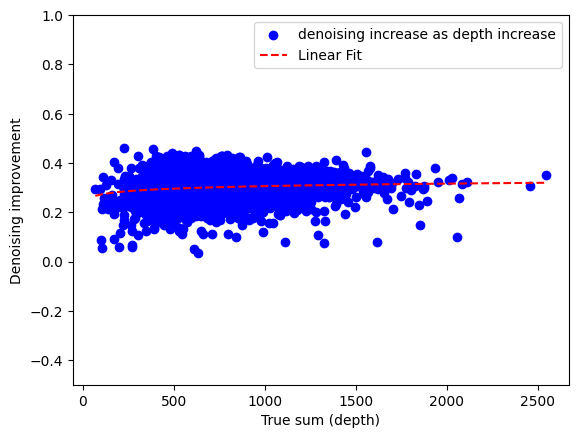

{'reco2noisy': np.float64(0.30610418980976806), 'reco2full': np.float64(0.7393976101673336), 'noisy2full': np.float64(0.4123824576973039)}
doing  lung_smart



/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 9409 renamining
filtered out 0 cells, 9409 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 15701 genes in the ontology but not present in the dataset
starting QC
Seeing 5471 outliers (58.14% of total dataset):
done
AnnData object with n_obs × n_vars = 9409 × 70116
    obs: 'nGene', 'nReads', 'plate.barcode', 'cell.id', 'region', 'label', 'sorter', 'sort.location', 'sample', 'location', 'donor_id', 'percent.ercc', 'percent.ribo', 'gating', 'free_annotation', 'Number of splices: Total', 'Number of splices: Annotated (sjdb)', 'Number of splices: GT-AG', 'Number of splices: GC-AG', 'Number of splices: AT-AC', 'Number of splices: Non-canonical', 'Mapping speed, Million of reads per hour', 'Average input read length', 'compartment', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 471/471 [00:51<00:00,  9.17it/s]


logging the anndata
AnnData object with n_obs × n_vars = 9409 × 4290
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
corr with zeros: 
{'reco2full': np.float64(0.21856345106815045), 'noisy2full': np.float64(0.7614486805108437)}
cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': np.float64(0.23118208398578702), 'cell_wise_to_noisy': np.float64(0.3586403618213593)}
depth-wise plot


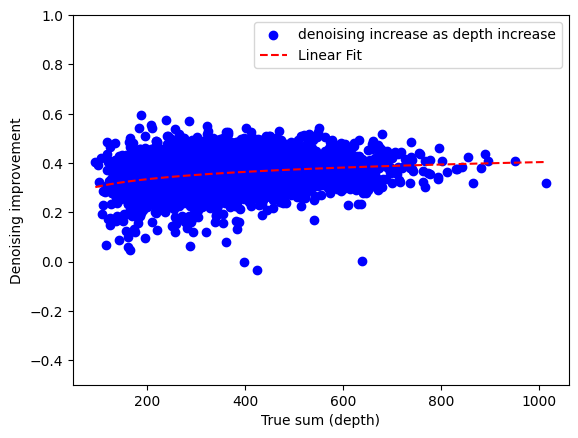

{'reco2noisy': np.float64(0.31872739531498495), 'reco2full': np.float64(0.7943597842307583), 'noisy2full': np.float64(0.40560519806937256)}
doing  SRX24486462

Dropping layers:  KeysView(LayersView with keys: ambiguous, norm, spliced, unspliced)
checking raw counts
removed 0 non primary cells, 5201 renamining
filtered out 0 cells, 5201 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 0 genes in the ontology but not present in the dataset
starting QC
Seeing 5091 outliers (97.87% of total dataset):
done
AnnData object with n_obs × n_vars = 5201 × 70116
    obs: 'gene_count', 'umi_count', 'SRX_accession', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'sex', 'sex_ontology_term_id', 'age', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'ethnicity', 'is_primary_data', 'cell_culture', 'nnz', 'n_genes', 'n_genes_by_cou

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 261/261 [01:02<00:00,  4.20it/s]


logging the anndata
AnnData object with n_obs × n_vars = 5201 × 5257
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
corr with zeros: 
{'reco2full': np.float64(0.5301579002010383), 'noisy2full': np.float64(0.6871261834244646)}
cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': np.float64(0.511013345233769), 'cell_wise_to_noisy': np.float64(0.3111136720472813)}
depth-wise plot


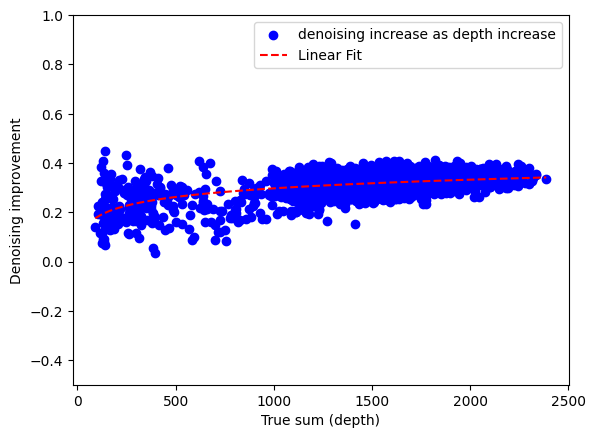

{'reco2noisy': np.float64(0.37761113904162874), 'reco2full': np.float64(0.729124674652336), 'noisy2full': np.float64(0.4051256132881622)}
doing  SRX22526970

Dropping layers:  KeysView(LayersView with keys: ambiguous, norm, spliced, unspliced)
checking raw counts
removed 0 non primary cells, 3110 renamining
filtered out 0 cells, 3110 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 0 genes in the ontology but not present in the dataset
starting QC
Seeing 766 outliers (24.62% of total dataset):
done
AnnData object with n_obs × n_vars = 3110 × 70116
    obs: 'gene_count', 'umi_count', 'SRX_accession', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'sex', 'sex_ontology_term_id', 'age', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'ethnicity', 'is_primary_data', 'cell_culture', 'nnz', 'n_genes', 'n_genes_by_counts

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 156/156 [00:36<00:00,  4.23it/s]


logging the anndata
AnnData object with n_obs × n_vars = 3110 × 5256
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
corr with zeros: 
{'reco2full': np.float64(0.5407820559757684), 'noisy2full': np.float64(0.7098346567900051)}
cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': np.float64(0.524510668778826), 'cell_wise_to_noisy': np.float64(0.39862515621975314)}
depth-wise plot


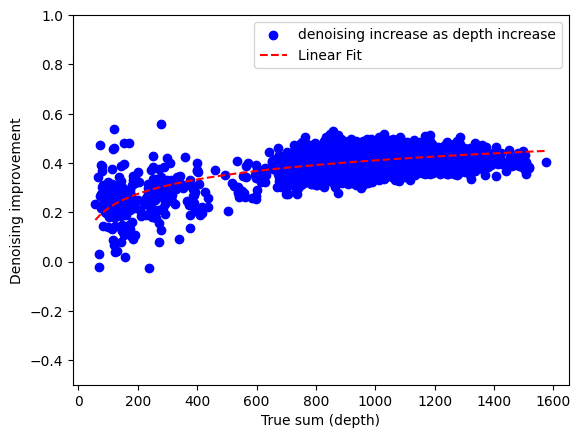

{'reco2noisy': np.float64(0.3863007478481227), 'reco2full': np.float64(0.8355559553533459), 'noisy2full': np.float64(0.4212905933733942)}


In [13]:
res = {}
for name, url in datasets.items():
    print("doing ", name)
    adata = sc.read(LOC + name + ".h5ad", backup_url=url)
    is_symbol = False
    if "organism_ontology_term_id" not in adata.obs.columns:
        adata.obs["organism_ontology_term_id"] = "NCBITaxon:9606"
        is_symbol = True
    preprocessor = Preprocessor(
        force_preprocess=True,
        skip_validate=True,
        is_symbol=is_symbol,
        # drop_non_primary=False,
        do_postp=model.expr_emb_style == "metacell",
    )
    print("")
    adata = adata[adata.X.sum(1) > 1000]
    adata = preprocessor(adata)
    if model.expr_emb_style == "metacell":
        sc.pp.neighbors(adata, use_rep="X_pca")
    print(adata.X.sum(1).mean())
    adata.layers["true"] = adata.X.copy()
    denoise = Denoiser(
        batch_size=40 if (adata.X > 0).sum(1).mean() < 2_000 else 20,
        max_len=8000,
        doplot=False,
        num_workers=8,
        predict_depth_mult=10,
        downsample_expr=0.7,
        additional_info=True,
        apply_zero_pred=True,  # False
    )
    res["scprint_" + name], idx, nadata = denoise(model, adata)
    print(res["scprint_" + name])

doing  retina



/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 51531 renamining
filtered out 0 cells, 51531 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 33737 genes in the ontology but not present in the dataset
starting QC
Seeing 24011 outliers (46.59% of total dataset):
normalize
starting PCA
done
AnnData object with n_obs × n_vars = 51531 × 70116
    obs: 'biosample_id', 'donor_id', 'cell_type_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type__custom', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'is_primary_data', 'age', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 1289/1289 [06:35<00:00,  3.26it/s]


logging the anndata
AnnData object with n_obs × n_vars = 51531 × 4661
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
corr with zeros: 
{'reco2full': np.float64(0.39049369393743244), 'noisy2full': np.float64(0.6936422922370957)}
cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': np.float64(0.36319994821003393), 'cell_wise_to_noisy': np.float64(0.3611453931684352)}
depth-wise plot


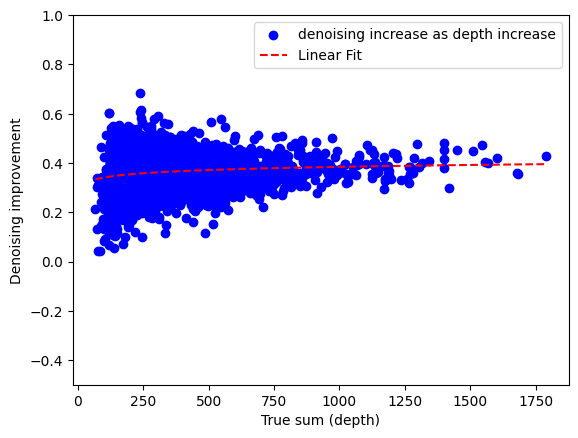

{'reco2noisy': np.float64(0.34507198992679117), 'reco2full': np.float64(0.7289601872476458), 'noisy2full': np.float64(0.3587355352958829)}
(51531, 4661)
Calculating MAGIC...
  Running MAGIC on 51531 cells and 4661 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 13.84 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.26 seconds.
    Calculating affinities...
    Calculated affinities in 3.66 seconds.
  Calculated graph and diffusion operator in 19.82 seconds.
  Calculating imputation...
  Calculated imputation in 0.70 seconds.
Calculated MAGIC in 21.40 seconds.
corr with zeros: 
{'reco2full': np.float64(0.4088768055590426), 'noisy2full': np.float64(0.6935474960739653)}
cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': np.float64(0.38654970138327677), 'cell_wise_to_noisy': np.float64(0.30919464613568365)}
depth-wise plot


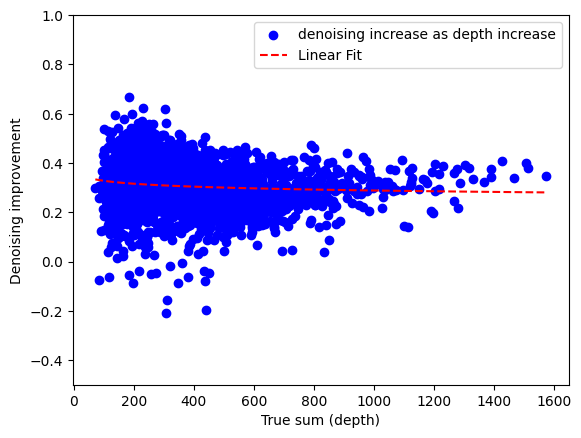

{'reco2noisy': np.float64(0.2574843561770031), 'reco2full': np.float64(0.6566697912651381), 'noisy2full': np.float64(0.3584584979451697)}
--------------------------------

doing  kidney



/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 39176 renamining
filtered out 0 cells, 39176 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 33718 genes in the ontology but not present in the dataset
starting QC
Seeing 3467 outliers (8.85% of total dataset):
normalize
starting PCA
done
AnnData object with n_obs × n_vars = 39176 × 70116
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rpl', 'percent.rps', 'doublet_id', 'nCount_SCT', 'nFeature_SCT', 's

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 1959/1959 [06:06<00:00,  5.35it/s]


logging the anndata
AnnData object with n_obs × n_vars = 39176 × 4792
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
corr with zeros: 
{'reco2full': np.float64(0.4257944394450777), 'noisy2full': np.float64(0.6839167884403655)}
cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': np.float64(0.4193269190512811), 'cell_wise_to_noisy': np.float64(0.31463033250897393)}
depth-wise plot


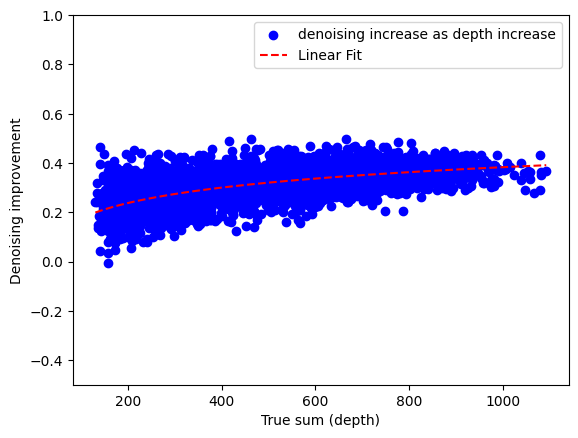

{'reco2noisy': np.float64(0.34299261080016114), 'reco2full': np.float64(0.6987444323975741), 'noisy2full': np.float64(0.3453435266974744)}
(39176, 4792)
Calculating MAGIC...
  Running MAGIC on 39176 cells and 4792 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 30.57 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.76 seconds.
    Calculating affinities...
    Calculated affinities in 1.90 seconds.
  Calculated graph and diffusion operator in 34.28 seconds.
  Calculating imputation...
  Calculated imputation in 0.33 seconds.
Calculated MAGIC in 35.36 seconds.
corr with zeros: 
{'reco2full': np.float64(0.46202591173368746), 'noisy2full': np.float64(0.683244528404357)}
cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': np.float64(0.44583698810028866), 'cell_wise_to_noisy': np.float64(0.23245574166025645)}
depth-wise plot


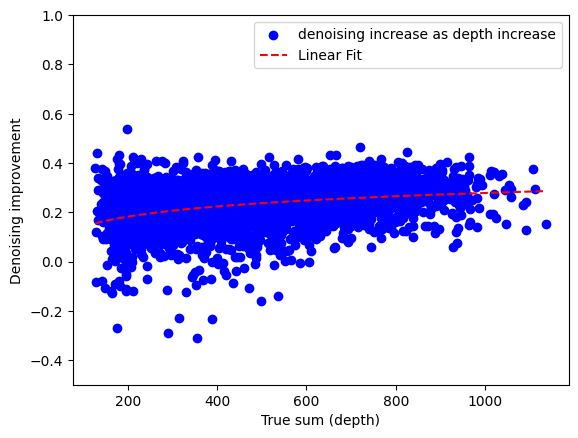

{'reco2noisy': np.float64(0.2273296528226122), 'reco2full': np.float64(0.6048574858819955), 'noisy2full': np.float64(0.34594913168181)}
--------------------------------

doing  pancreas

X was not raw counts, using 'counts' layer


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


Dropping layers:  KeysView(LayersView with keys: counts)
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 16382 renamining
filtered out 0 cells, 16382 renamining
Removed 1068 genes not known to the ontology
Removed 0 duplicate genes
Added 52091 genes in the ontology but not present in the dataset
starting QC
Seeing 4678 outliers (28.55% of total dataset):
normalize
starting PCA
done
AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'batches'
    var: 'uid', 'symbol', 'biotype', 'o

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name


100%|██████████| 820/820 [03:42<00:00,  3.68it/s]


logging the anndata
AnnData object with n_obs × n_vars = 16382 × 7850
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_cell_type_ontology_term_id'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'
corr with zeros: 
{'reco2full': np.float64(0.4210143477438469), 'noisy2full': np.float64(0.7243054824872335)}
cell_wise self corr (reco, noisy, true)
{'cell_wise_w_zero': np.float64(0.39649831122836865), 'cell_wise_to_noisy': np.float64(0.3234532061701522)}
depth-wise plot


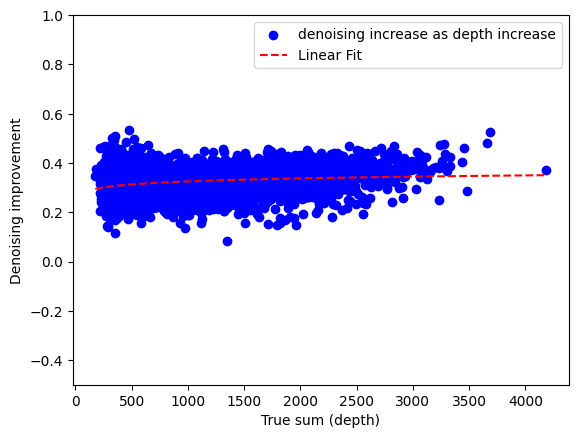

{'reco2noisy': np.float64(0.34158938353222257), 'reco2full': np.float64(0.7801074921483103), 'noisy2full': np.float64(0.40007148023436523)}
(16382, 7850)
Calculating MAGIC...
  Running MAGIC on 16382 cells and 7850 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 12.03 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.31 seconds.
    Calculating affinities...
    Calculated affinities in 0.35 seconds.
  Calculated graph and diffusion operator in 12.72 seconds.
  Calculating imputation...
  Calculated imputation in 0.07 seconds.
Calculated MAGIC in 13.29 seconds.


In [ ]:
res = {}
for name, url in datasets.items():
    print("doing ", name)
    adata = sc.read(LOC + name + ".h5ad", backup_url=url)
    is_symbol = False
    if "organism_ontology_term_id" not in adata.obs.columns:
        adata.obs["organism_ontology_term_id"] = "NCBITaxon:9606"
        is_symbol = True
    preprocessor = Preprocessor(
        force_preprocess=True,
        skip_validate=True,
        is_symbol=is_symbol,
        # drop_non_primary=False,
        do_postp=model.expr_emb_style == "metacell",
    )
    print("")
    adata = adata[adata.X.sum(1) > 1000]
    adata = preprocessor(adata)
    if model.expr_emb_style == "metacell":
        sc.pp.neighbors(adata, use_rep="X_pca")
    print(adata.X.sum(1).mean())
    adata.layers["true"] = adata.X.copy()
    denoise = Denoiser(
        batch_size=40 if (adata.X > 0).sum(1).mean() < 2_000 else 20,
        max_len=8000,
        doplot=False,
        num_workers=8,
        predict_depth_mult=10,
        downsample_expr=0.7,
        additional_info=True,
        apply_zero_pred=True,  # False
    )
    res["scprint_" + name], idx, nadata = denoise(model, adata)
    print(res["scprint_" + name])

    # doing magic
    subadata = (
        adata[idx, adata.var.index.isin(model.genes) & adata.var.highly_variable].copy()
        if idx is not None
        else adata[
            :, adata.var.index.isin(model.genes) & adata.var.highly_variable
        ].copy()
    )
    print(subadata.shape)
    subadata.X = downsample_profile(torch.Tensor(subadata.X.toarray()), 0.7)
    denoised_adata = sc.external.pp.magic(
        subadata.copy(), copy=True, n_jobs=10, solver="approximate", verbose=True
    )

    reco = denoised_adata.X
    true = subadata.layers["true"].toarray()
    noisy = subadata.X
    corr_coef, p_value = spearmanr(
        np.vstack([reco[true != 0], noisy[true != 0], true[true != 0]]).T
    )
    res["magic_" + name] = {
        "reco2noisy": corr_coef[0, 1],
        "reco2full": corr_coef[0, 2],
        "noisy2full": corr_coef[1, 2],
    }
    if reco.shape[0] >= 3000:
        indices = np.random.choice(reco.shape[0], 3000, replace=False)
        reco = reco[indices]
        noisy = noisy[indices]
        true = true[indices]
    corr, p_value = spearmanr(
        np.vstack(
            [
                reco.flatten(),
                noisy.flatten(),
                true.flatten(),
            ]
        ).T
    )
    m = {
        "reco2full": corr[0, 2],
        "noisy2full": corr[1, 2],
    }
    print("corr with zeros: ")
    print(m)
    cell_wise = np.array(
        [
            spearmanr(reco[i][true[i] != 0], true[i][true[i] != 0])[0]
            for i in range(reco.shape[0])
        ]
    )
    torm = np.array(
        [
            spearmanr(noisy[i][true[i] != 0], true[i][true[i] != 0])[0]
            for i in range(reco.shape[0])
        ]
    )
    cell_wise -= torm
    cell_wise_zero = np.mean(
        [spearmanr(reco[i], true[i])[0] for i in range(reco.shape[0])]
    )
    print("cell_wise self corr (reco, noisy, true)")
    print(
        {
            "cell_wise_w_zero": cell_wise_zero,
            "cell_wise_to_noisy": np.mean(cell_wise),
        }
    )
    print("depth-wise plot")
    plot_cell_depth_wise_corr_improvement(cell_wise, (true > 0).sum(1))
    print(res["magic_" + name])
    print("--------------------------------")
    print("")

In [8]:
res

{'scprint_retina': {'reco2noisy': np.float64(0.34507198992679117),
  'reco2full': np.float64(0.7289601872476458),
  'noisy2full': np.float64(0.3587355352958829)},
 'magic_retina': {'reco2noisy': np.float64(0.2574843561770031),
  'reco2full': np.float64(0.6566697912651381),
  'noisy2full': np.float64(0.3584584979451697)},
 'scprint_kidney': {'reco2noisy': np.float64(0.34299261080016114),
  'reco2full': np.float64(0.6987444323975741),
  'noisy2full': np.float64(0.3453435266974744)},
 'magic_kidney': {'reco2noisy': np.float64(0.2273296528226122),
  'reco2full': np.float64(0.6048574858819955),
  'noisy2full': np.float64(0.34594913168181)},
 'scprint_pancreas': {'reco2noisy': np.float64(0.34158938353222257),
  'reco2full': np.float64(0.7801074921483103),
  'noisy2full': np.float64(0.40007148023436523)},
 'magic_pancreas': {'reco2noisy': np.float64(0.26774555366657726),
  'reco2full': np.float64(0.6309373343709963),
  'noisy2full': np.float64(0.3995623760601987)},
 'scprint_intestine': {'rec

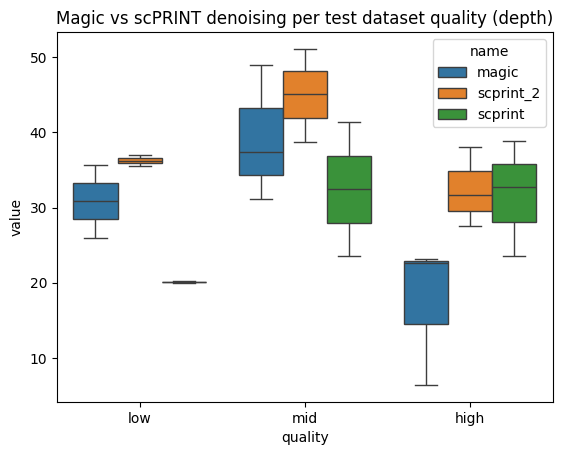

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit

# Create a DataFrame
# from prevmodel
# data = {
#    'depth': [2736, 1888, 388362, 10360],
#    'magic': [30.4, 26.3, 6.4, 27.0],
#    'scprint': [19.3, 21.5, 33.2, 36.1]
# }
# from the prevmodel
# data = {
#    "depth": [1888, 2736, 388362, 10360, 21693, 38469],
#    "magic": [25, 28.7, 17.6, 27.6, 49, 37.1],
#    "scprint": [26, 27.6, 29.8, 28.2, 47.7, 37.1],
# }

data = {
    "depth": [3_800, 5_300, 13_000, 21_693, 38_469, 160_000, 400_000, 1_000_000],
    # "magic": [25, 28.6, 32, 49, 37.1, 20, 12.6, 25], # RUN1
    # "scprint": [26, 25, 40, 51.5, 43.1, 32, 39, 44],
    "magic": [35.7, 26.0, 31.2, 49.0, 37.4, 22.6, 6.4, 23.1],  # RUN2
    "scprint_2": [37, 35.5, 38.7, 51.1, 45.1, 31.6, 27.6, 38.0],
    # scprint_2_noise_nn: [29.8 27.6, 40.0, 51.3, 45.1, 36.0, 30.7, 33.5]
    "scprint": [20.2, 20, 23.5, 32.4, 41.4, 23.5, 32.7, 38.9],
    "quality": ["low", "low", "mid", "mid", "mid", "high", "high", "high"],
}

# smart-seq: 25-44 & 13-39

df = pd.DataFrame(data)
df = df.melt(
    id_vars=["quality"],
    value_vars=["magic", "scprint_2", "scprint"],
    var_name="name",
    value_name="value",
)
sns.boxplot(data=df, x="quality", y="value", hue="name")


# Add labels and legend
plt.title("Magic vs scPRINT denoising per test dataset quality (depth)")
plt.show()